In [251]:
import pandas as pd 
import numpy as np
from scipy.stats import t
import seaborn as sns

In [75]:
payments = pd.read_csv('payments.csv')
payments.head(5)

,timestamp,user_id,event_name,is_trial,price
0,1514754000,59c856ca5638e80001b8bad2,payment,False,2.99
1,1514755080,32eb44a1-4c44-49e1-8322-253ef00ac52c,payment,True,0.00
2,1514756460,acfaee6d-abe2-4c8c-a243-98331eb5a736,payment,True,0.00
3,1514762280,58c2e0bf-6fd6-4f79-bcc1-9c21e2ef0e0a,payment,True,0.00
4,1514763480,1cd8ccf6-09a0-4dc8-ab9b-786c392ca3e4,payment,True,0.00


In [76]:
sessions = pd.read_csv('sessions.csv')
sessions.head(5)

,timestamp,user_id,test_group,event_name
0,1514768820,ab3a0b4e-6286-4748-90a1-e7d58273594d,05_12FTD_control_group,session start
1,1514782260,e64698c1-0168-4523-9592-f5226e63b9e6,05_12FTD_control_group,session start
2,1514811780,a8436498-ca01-4f09-9bac-de1bf217e00e,05_12FTD_control_group,session start
3,1514831460,6e5830b2-85b7-44b3-b7dd-3cb2e18c2897,05_12FTD_test_group,session start
4,1514831940,3b1809fe-e495-49e2-a8d1-b888d0a6948e,05_12FTD_control_group,session start


Переименуем колонки для более удобного восприятия

In [16]:
payments.columns

Index(['#0 timestamp', '#1 user id', '#2 Event name', '#3 is_trial', 'price'], dtype='object')

In [17]:
payments.columns = ['timestamp', 'user_id', 'event_name', 'is_trial', 'price']

In [18]:
sessions.columns

Index(['#0 timestamp', '#1 user id', '#2 Test group', '#3 Event name'], dtype='object')

In [19]:
sessions.columns = ['timestamp', 'user_id', 'test_group', 'event_name']

Посмотрим на количество уникальных значения user_id

In [20]:
payments.user_id.nunique()

2543

In [21]:
sessions.user_id.nunique()

2218

Cоединим таблицы и удалим дублирующие строки

In [167]:
df = payments.merge(sessions.drop_duplicates(
    subset=['user_id'], keep='first'), on=['user_id'], how='left')
df

,timestamp_x,user_id,event_name_x,is_trial,price,timestamp_y,test_group,event_name_y
0,1514754000,59c856ca5638e80001b8bad2,payment,False,2.99,NaN,NaN,NaN
1,1514755080,32eb44a1-4c44-49e1-8322-253ef00ac52c,payment,True,0.00,NaN,NaN,NaN
2,1514756460,acfaee6d-abe2-4c8c-a243-98331eb5a736,payment,True,0.00,NaN,NaN,NaN
3,1514762280,58c2e0bf-6fd6-4f79-bcc1-9c21e2ef0e0a,payment,True,0.00,NaN,NaN,NaN
4,1514763480,1cd8ccf6-09a0-4dc8-ab9b-786c392ca3e4,payment,True,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4260,1517429700,59b60e2b5638e800019776a7,payment,False,2.99,NaN,NaN,NaN
4261,1517430900,b9e6387f-9a66-4951-b569-6f42185d52c0,payment,True,0.00,NaN,NaN,NaN
4262,1517431080,80378737-946c-4309-b2ff-bdef513ff815,payment,True,0.00,NaN,NaN,NaN
4263,1517431200,402e5074-360b-416d-b3fc-d7c29c9ab2c3,payment,False,7.99,NaN,NaN,NaN


Посмотрим на количество пользователей в каждой из групп (тестовая и контрольная)

In [204]:
df.pivot_table(columns='test_group', values='price', aggfunc='count')

test_group,05_12FTD_control_group,05_12FTD_test_group
price,121,118


In [186]:
df.pivot_table(columns='test_group', values='price', aggfunc='sum')

test_group,05_12FTD_control_group,05_12FTD_test_group
price,519.35,575.4


Ищем стат значимые различия при помощи графика

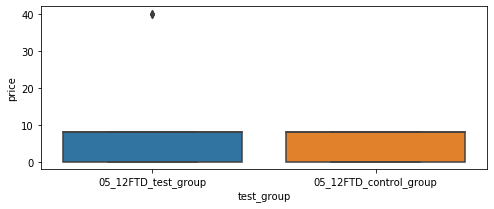

In [199]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(x='test_group', y='price', data=df, ax=ax)

#### Выдвигам гипотезу  

Т.к. при запуске приложения пользователю предлагают приобрести некоторое количество внутриигровой валюты для открытия последующих история, то выдвинем следующие гипотезы:

Hо : средний чек в контрольной группе равен этому же показателю в тестовой группе

H1 : средний чек в контрольной группе выше, чем в тестовой


Проверяем наши гипотезы путем расчета t-статистики и p-value на 5% уровне значимости

In [220]:
mean_c = np.array(df[df.test_group == '05_12FTD_control_group'].price).mean()
mean_t = np.array(df[df.test_group == '05_12FTD_test_group'].price).mean()
std_c = np.array(df[df.test_group == '05_12FTD_control_group'].price).std()
std_t = np.array(df[df.test_group == '05_12FTD_test_group'].price).std()

In [255]:
t_st = (mean_c - mean_t)/np.sqrt((std_c**2)/121 + (std_t**2)/118)
print(round(t_st,3))

-0.798


In [265]:
round(t.cdf(t_st,237),3)

0.213

## Вывод:
Полученный результат не дает нам возможности отвергнуть Ho в виду недостаточного количества наблюдений

P.s. проверил еще гипотезу о количестве покупок (результат вышел аналогичный)